In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from keras.models import Model

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [3]:
random_state = 42

# data load

In [40]:
data_1 = pd.read_csv('./data/raw_data.csv')
data_2 = pd.read_csv('./data/raw_data2.csv')

data_1 = data_1.dropna(axis=1, how='all') #결측치 열 삭제
data_2 = data_2.dropna(axis=1, how='all') #결측치 열 삭제

In [43]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      70000 non-null  int64  
 1   PC1_SP          70000 non-null  float64
 2   PC2_SP          70000 non-null  float64
 3   FC_SP           70000 non-null  int64  
 4   TC_SP           70000 non-null  float64
 5   TC2_SP          70000 non-null  float64
 6   RR1_SP          70000 non-null  float64
 7   RR2_SP          70000 non-null  float64
 8   TCF             70000 non-null  float64
 9   PC1             70000 non-null  float64
 10  PC2             70000 non-null  float64
 11  TC1             70000 non-null  float64
 12  TC2             70000 non-null  float64
 13  Column1 D       70000 non-null  float64
 14  Column2 D       70000 non-null  float64
 15  Column1 reflux  70000 non-null  float64
 16  Column2 reflux  70000 non-null  float64
 17  Column1 B       70000 non-null 

## train/test split

In [72]:
test_ratio = 0.1

data_size = len(data_1) + len(data_2)
test_size = int(data_size*test_ratio)
data_train = pd.concat([data_1, data_2[:-test_size]], axis=0)
data_test = data_2[-test_size:]

print("data_train:", data_train.shape)
print("data_test:", data_test.shape)

data_train: (126000, 23)
data_test: (14000, 23)


## variables

In [73]:
set_points = ['PC1_SP', 'PC2_SP', 'FC_SP', 'TC_SP', 'TC2_SP', 
              'RR1_SP', 'RR2_SP', 'TCF']
process_vars = ['PC1', 'PC2', 'TC1', 'TC2', 'Column1 D', 'Column2 D',
                'Column1 reflux', 'Column2 reflux', 'Column1 B', 'Column2 B',
                'Column1 Qcond', 'Column2 Qcond', 'Column1 Qreb', 'Column2 Qreb']

## data scaling

In [79]:
# select data considered
all_vars = set_points + process_vars

df_train = data_train[all_vars]
df_test = data_test[all_vars]

# Obtain mean and std
mean = df_train.mean(axis=0)
std = df_train.std(axis=0)

# scaled dataset
df_train_sc = (df_train-mean)/std
df_test_sc = (df_test-mean)/std

## data to sequence

**encoder_input**: history of `set points` and `process variables`

**decoder_input**: future `set points`

**decoder_output**: prediction of future `process variables`

In [82]:
def data2sequence(dataframe, 
                  set_points, process_vars,
                  history_size, prediction_size, 
                  step=1, start_idx=0, end_idx=None,
                  stride=1):
    
    history_inputs = set_points + process_vars
    target_outputs = process_vars
        
    history_data = dataframe[history_inputs].values
    target_data = dataframe[target_outputs].values
    sp_data = dataframe[set_points].values
    
    history_sequence = []
    target_sequence = []
    sp_sequence = []
    
    if end_idx is None:
        end_idx = len(dataframe) - history_size - prediction_size
    else:
        end_idx = end_idx - history_size - prediction_size
    assert end_idx >= 0, 'time-series dataset is not long enough'
    
    i=start_idx
    while i <= end_idx:
        history_sequence.append(history_data[range(i, i+history_size, step)])
        if prediction_size == 1:
            target_sequence.append(target_data[i+history_size])
            sp_sequence.append(sp_data[i+history_size])
        else:
            target_sequence.append(target_data[i+history_size : i+history_size+prediction_size : step])
            sp_sequence.append(sp_data[i+history_size : i+history_size+prediction_size : step])
        i+=stride
    
    encoder_input = np.array(history_sequence)
    decoder_input = np.array(sp_sequence)
    decoder_output = np.array(target_sequence)
    
    return encoder_input, decoder_input, decoder_output

# single-step ahead prediction

In [83]:
history_size = 350
prediction_size = 1
stride = 5

encoder_input, decoder_input, decoder_output = data2sequence(df_train_sc, 
                                                             set_points, process_vars,
                                                             history_size, prediction_size,
                                                             stride=stride)
print("Train dataset")
print("encoder_input:", encoder_input.shape)
print("decoder_input:", decoder_input.shape)
print("decoder_output:", decoder_output.shape)
print("")

Train dataset
encoder_input: (25130, 350, 22)
decoder_input: (25130, 8)
decoder_output: (25130, 14)



## RNN model

> **squence-to-vector learning** <br>
> input sequence: (sample_size, history_size, # of input_vars) <br>
> output sequence: (sample_size, # of output_vars)

In [84]:
def Seq2VecLSTM(
    history_size, history_dim, 
    prediction_size, prediction_dim,
    rnn_neurons = [100], dense_neurons = [100]
):
    encoder_input = Input(shape=(history_size, history_dim))
    
    # encoder module
    if len(rnn_neurons) == 1:
        encoder_output, state_h, state_c = LSTM(rnn_neurons[0], return_state=True, name='encoder')(encoder_input)
        encoder_states = [state_h, state_c]
        
    else:
        num_layers = len(rnn_neurons)
        for i, neurons in enumerate(rnn_neurons):
            #first encoder layer
            if i==0: 
                encoder_output = LSTM(neurons, return_sequences=True, name="first_encoder")(encoder_input)
            #mediate encoder layer
            elif i < num_layers-1: 
                encoder_output = LSTM(neurons, return_sequences=True, name=f"encoder_{i+1}")(encoder_output)
            #last encoder layer
            else: 
                encoder_output, state_h, state_c  = LSTM(neurons, return_state=True, name=f"last_encoder")(encoder_output)
                encoder_states = [state_h, state_c]
    
    # context + set_point
    sp_input = Input(shape=(history_dim-prediction_dim))
    combined_input = concatenate([encoder_output, sp_input])
    
    # dense module
    if len(dense_neurons) == 1:
        dense_output = Dense(prediction_dim, name='dense')(combined_input)
        dense_output = Dense(prediction_dim, name='last_dense')(dense_output)
    else:
        num_layers = len(dense_neurons)
        for i, neurons in enumerate(dense_neurons):
            #first dense layer
            if i==0:
                dense_output = Dense(neurons, name='first_dense')(combined_input)
            #mediate encoder layer
            else:
                dense_output = Dense(neurons, name=f'dense_{i+1}')(dense_output)
        dense_output = Dense(prediction_dim, name=f'last_dense')(dense_output)  
    
    # model compile
    model = Model([encoder_input, sp_input], dense_output)
    optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='mse', optimizer = optimizer)
    
    return model

bulid model

In [27]:
history_dim = len(set_points+process_vars)
prediction_dim = len(process_vars)
rnn_neurons = [100, 10]
dense_neurons = [100, 10]

rnn_model = Seq2VecLSTM(history_size, history_dim,
                        prediction_size, prediction_dim,
                        rnn_neurons = rnn_neurons, dense_neurons = dense_neurons
)

rnn_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 350, 22)]    0           []                               
                                                                                                  
 first_encoder (LSTM)           (None, 350, 100)     49200       ['input_7[0][0]']                
                                                                                                  
 last_encoder (LSTM)            [(None, 10),         4440        ['first_encoder[0][0]']          
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                            

model training

In [29]:
from keras.callbacks import EarlyStopping

patience = 20
monitor='val_loss'
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights= True, monitor=monitor)

epochs = 10000
verbose = 2
batch_size = 64
validation_split = 0.15

tf.random.set_seed(random_state)
history = rnn_model.fit([encoder_input, decoder_input], decoder_output,
                        epochs=epochs, batch_size = batch_size,
                        callbacks=[early_stopping_cb], verbose=verbose,validation_split=validation_split)

Epoch 1/10000
334/334 - 12s - loss: 0.2326 - val_loss: 0.1265 - 12s/epoch - 35ms/step
Epoch 2/10000
334/334 - 8s - loss: 0.0536 - val_loss: 0.0686 - 8s/epoch - 24ms/step
Epoch 3/10000
334/334 - 8s - loss: 0.0354 - val_loss: 0.0537 - 8s/epoch - 24ms/step
Epoch 4/10000
334/334 - 8s - loss: 0.0299 - val_loss: 0.0479 - 8s/epoch - 24ms/step
Epoch 5/10000
334/334 - 8s - loss: 0.0270 - val_loss: 0.0455 - 8s/epoch - 24ms/step
Epoch 6/10000
334/334 - 8s - loss: 0.0258 - val_loss: 0.0435 - 8s/epoch - 24ms/step
Epoch 7/10000
334/334 - 8s - loss: 0.0247 - val_loss: 0.0434 - 8s/epoch - 24ms/step
Epoch 8/10000
334/334 - 8s - loss: 0.0242 - val_loss: 0.0427 - 8s/epoch - 24ms/step
Epoch 9/10000
334/334 - 8s - loss: 0.0241 - val_loss: 0.0414 - 8s/epoch - 24ms/step
Epoch 10/10000
334/334 - 8s - loss: 0.0237 - val_loss: 0.0413 - 8s/epoch - 24ms/step
Epoch 11/10000
334/334 - 8s - loss: 0.0235 - val_loss: 0.0416 - 8s/epoch - 24ms/step
Epoch 12/10000
334/334 - 8s - loss: 0.0233 - val_loss: 0.0415 - 8s/epoch

model test

In [177]:
history_size = 350
unit_size = 350

test_result = []
for k in range(1, 41):
    print(k, "th test")
    # set_point and actual value
    setpoint = df_test[set_points].iloc[history_size*k:history_size*k+unit_size].values
    actual = df_test[process_vars].iloc[history_size*k:history_size*k+unit_size].values
    
    prediction = []
    test_input = df_test_sc[all_vars].iloc[history_size*(k-1):history_size*k].values[np.newaxis]
    for i in range(unit_size):
        test_setpoint = df_test_sc[set_points].iloc[[i+history_size*k]].values

        # prediction
        prediction_sc = rnn_model.predict([test_input, test_setpoint], verbose=0)
        prediction.append(prediction_sc[0])

        # update input
        new_input = np.concatenate([test_setpoint, prediction_sc], axis=1)[np.newaxis]
        test_input = np.delete(test_input, 0, axis=1)
        test_input = np.concatenate([test_input, new_input], axis=1)
    
    # prediction
    prediction_sc = np.array(prediction)
    prediction = prediction_sc*std[process_vars].values + mean[process_vars].values
    
    test_result.append([setpoint, actual, prediction])

1 th test
2 th test
3 th test
4 th test
5 th test
6 th test
7 th test
8 th test
9 th test
10 th test
11 th test
12 th test
13 th test
14 th test
15 th test
16 th test
17 th test
18 th test
19 th test
20 th test


KeyboardInterrupt: 

plot test result

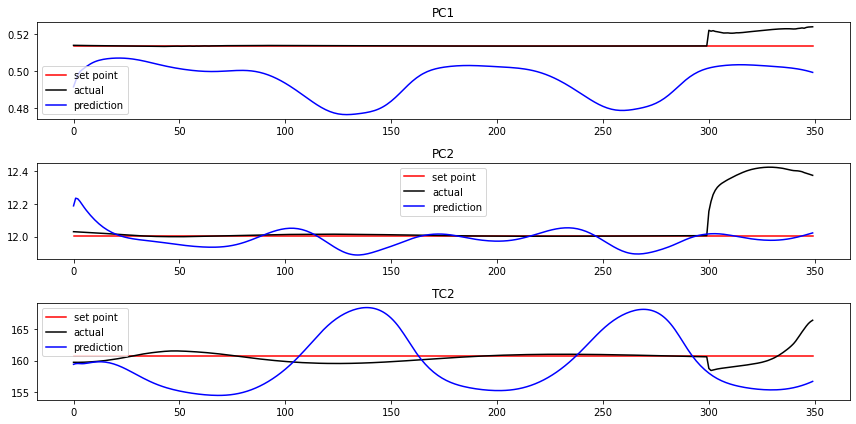

In [198]:
plot_var = ['PC1', 'PC2', 'TC2']
set_num = [0, 1, 4]

test_num = 4
setpoint = test_result[test_num][0]
actual = test_result[test_num][1]
prediction = test_result[test_num][2]

rows = len(plot_var)
columns = 1
size = 2

plt.figure(figsize=(12*columns, size*rows))
i=0
for j, var in enumerate(process_vars):
    if var in plot_var:
        plt.subplot(rows,1,i+1)
        plt.plot(setpoint[:,set_num[i]], label='set point', color='r')
        plt.plot(actual[:,j], label='actual', color='k')
        plt.plot(prediction[:,j], label='prediction', color='b')
        plt.title(var)
        plt.legend()
        i+=1
plt.tight_layout()